In [1]:
#%source bin/activate
import tensorflow as tf
import os
import random
import time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
rundir = "/home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/"
trndir = rundir+"train/"
testdir = rundir+"test/"
bThetas = True
NLBL = 4

trnlist = ["tjam_th", "xjam_th"]
# trnlist = ["edge15.00", "edge30.00"]
testlist = ["tjam_th", "xjam_th"]
# testlist = ["edge15.00", "edge30.00"]

if trnlist == [""]:
    trnlist = [trndir+x for x in os.listdir(trndir)]
else:
    trnlist = [trndir+x for x in trnlist]
if testlist == [""]:
    testlist = [testdir+x for x in os.listdir(testdir)]
else:
    testlist = [testdir+x for x in testlist]

In [3]:
# Compile training set
trn_data = []
trn_inputs = []
trn_labels = []

nTrnPerFile = 8000
shufIdx = [p for p in range(400)]
random.shuffle(shufIdx)
            
for f in trnlist:
    print "Processing " + f + " as training data"
    thetas = []
    xs = []
    ys = []
    fin = open(f, 'r')
    nTrn = 0
    for line in fin.readlines():
        if line == "\n": continue
        if line.startswith("label"):
            # Done a block
            lbl = int(float(line.split()[1]))
            lbls[lbl] = 1
            trn_labels.append(lbls)
            
            if bThetas:
                # Insert theta data
                formatted_data = np.zeros(shape=(400,1))
                random.shuffle(shufIdx)
                for s in shufIdx:
                    formatted_data[s] = [thetas[s]]
                trn_inputs.append(formatted_data)
            else:
                # Insert data as triplets
                formatted_data = np.zeros(shape=(400,3))
                random.shuffle(shufIdx)
                for s in shufIdx:
                    formatted_data[s] = [xs[s],ys[s],thetas[s]]
                trn_inputs.append(formatted_data)
                
            thetas = []
            xs = []
            ys = []
            nTrn+=1
            if nTrn == nTrnPerFile: 
                break
            continue
        spt = [float(x) for x in line.split()]
        xs.append(spt[0])
        ys.append(spt[1])
        thetas.append(spt[2])

    fin.close()
        
for i in range(len(trn_inputs)):
    trn_data.append([trn_inputs[i], trn_labels[i]])
    
random.shuffle(trn_data)

print "Done compiling training set"

Processing /home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/train/tjam_th as training data


NameError: name 'lbls' is not defined

In [4]:
test_data = []
test_inputs = []
test_labels = []

for f in testlist:
    print "Adding " + f + " to test set"
    thetas = []
    xs = []
    ys = []
    fin = open(f, 'r')
    nTrn = 0
    for line in fin.readlines():
        if line == "\n": continue
        if line.startswith("label"):
            # Done a block
            lbl = int(float(line.split()[1]))
            lbls[lbl] = 1
            test_labels.append(lbls)
            if bThetas:
                # Insert theta data
                formatted_data = np.zeros(shape=(400,1))
                random.shuffle(shufIdx)
                for s in shufIdx:
                    formatted_data[s] = [thetas[s]]
                test_inputs.append(formatted_data)
            else:
                # Insert data as triplets
                formatted_data = np.zeros(shape=(400,3))
                random.shuffle(shufIdx)
                for s in shufIdx:
                    formatted_data[s] = [xs[s],ys[s],thetas[s]]
                test_inputs.append(formatted_data)
            thetas = []
            xs = []
            ys = []
            nTrn+=1
            if nTrn == nTrnPerFile: 
                break
            continue
        spt = [float(x) for x in line.split()]
        xs.append(spt[0])
        ys.append(spt[1])
        thetas.append(spt[2])

    fin.close()
for i in range(len(test_inputs)):
    test_data.append([test_inputs[i], test_labels[i]])

print "Done"

Adding /home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/test/tjam to test set
Adding /home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/test/xjam to test set
Done


In [5]:
print len(trn_data), len(test_data)

16000 1000


In [6]:
class runrecord:
    def __init__(self,
                trnlist,
                testlist,
                bThetas,
                sizedict,
                batchsize,
                eta,
                keepprob,                
                nEpoch):
        self.params = {
            "trnlist":trnlist,
            "testlist":testlist,
            "bThetas":bThetas,
            "batchsize":batchsize,
            "eta":eta,
            "keepprob":keepprob,
            "nEpoch":nEpoch
        }
        
        self.sizedict=sizedict
        self.testacc = np.zeros(shape=(nEpoch,))        
        self.trnacc = np.zeros(shape=(nEpoch,))        
        self.testlosses = np.zeros(shape=(nEpoch,))        
        self.trnlosses = np.zeros(shape=(nEpoch,))

In [9]:
records = []

In [7]:
batchsize = 200
nInput = 400
inChan = 3
if bThetas: inChan = 1
imgheight,imgwidth = 1,nInput

# Divide by stride*stride for each conv layer
filtwidth = 1
stride = 1
conv1_nOut = 3 # 32
# conv2_nOut = 64
fc1_nIn = imgheight*imgwidth*conv1_nOut/(stride*stride*stride*stride)
fc1_nOut = 200

eta = 1e-3

sizedict = {"nInput":nInput,
            "inChan":inChan,
            "imgheight":imgheight,
            "imgwidth":imgwidth,
            "filtwidth":filtwidth,
            "stride":stride,
            "conv1_nOut":conv1_nOut,
            "fc1_nIn":fc1_nIn,
            "fc1_nOut":fc1_nOut
           }

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def conv2d(x, W):
    s = stride
    return tf.nn.conv2d(x, W, strides=[1,s,s,1], padding='SAME')


x = tf.placeholder(tf.float32, shape=[None, nInput, inChan])
y_ = tf.placeholder(tf.float32, shape=[None, NLBL])

x_image = tf.reshape(x, [-1, imgheight, imgwidth, inChan])
keep_prob = tf.placeholder(tf.float32)

W_conv1 = weight_variable([filtwidth, filtwidth, inChan, conv1_nOut]) # [x,y,nInputChannel,nOutChannel]
b_conv1 = bias_variable([conv1_nOut])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

# W_conv2 = weight_variable([filtwidth, filtwidth, conv1_nOut, conv2_nOut])
# b_conv2 = bias_variable([conv2_nOut])
# h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2) + b_conv2)

W_fc1 = weight_variable([fc1_nIn, fc1_nOut])
b_fc1 = bias_variable([fc1_nOut])
h_conv1_flat = tf.reshape(h_conv1, [-1, fc1_nIn])
h_fc1 = tf.nn.dropout(tf.nn.relu(tf.matmul(h_conv1_flat, W_fc1) + b_fc1), keep_prob)

W_fc2 = weight_variable([fc1_nOut, NLBL])
b_fc2 = bias_variable([NLBL])

zout = tf.matmul(h_fc1,W_fc2)+b_fc2
y_out = tf.nn.softmax(zout)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=zout))

train_step = tf.train.AdamOptimizer(eta).minimize(cost)
correct_prediction = tf.equal(tf.argmax(y_out, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [14]:
# Remove most recent run from records
tmp = list(records)
records = []
for r in tmp[0:-1]:
    records.append(r)

In [11]:
nEpoch = 400
py_keepprob = .8

thisrecord = runrecord(trnlist,testlist,bThetas,sizedict,batchsize,eta,py_keepprob,nEpoch)
records.append(thisrecord)

random.shuffle(trn_data)
random.shuffle(test_data)
xtest = np.asarray([test_data[i][0] for i in xrange(len(test_data))])
ytest = np.asarray([test_data[i][1] for i in xrange(len(test_data))])

print xtest.shape

# sess = tf.Session()
# sess.run(tf.global_variables_initializer())
# with sess.as_default():
#     assert tf.get_default_session() is sess
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(nEpoch):
        # Shuffle data
        random.shuffle(trn_data)

        for b in range(len(trn_data)/batchsize):
            ib = b*batchsize
            # Pepare a batch
            xin = np.asarray([trn_data[ib+iib][0] for iib in xrange(batchsize)])
            yin = np.asarray([trn_data[ib+iib][1] for iib in xrange(batchsize)])
            train_step.run(feed_dict={x:xin, y_:yin, keep_prob:py_keepprob})

        if e % 2 == 0:
            # Cost from trn data
            xin = np.asarray([trn_data[iib][0] for iib in xrange(batchsize)])
            yin = np.asarray([trn_data[iib][1] for iib in xrange(batchsize)])
            trnacc, trncost = sess.run([accuracy,cost],feed_dict={x:xin, y_:yin, keep_prob:1.0})
            # Eval on test set
            test_accuracy, youts, testcost = sess.run([accuracy,y_out,cost],feed_dict={
                x: xtest, y_: ytest, keep_prob: 1.0})
            print('epoch %d, trnacc %g, test accuracy %g, trncost %g, testcost %g' 
                  % (e,trnacc,test_accuracy,trncost,testcost))
            thisrecord.testlosses[e] = testcost
            thisrecord.trnlosses[e] = trncost
            thisrecord.testacc[e] = test_accuracy
            thisrecord.trnacc[e] = trnacc
            
            
# sess.close()
print "Done"

(1000, 400, 1)
epoch 0, trnacc 1, test accuracy 1, trncost 5.7717e-05, testcost 5.76378e-05
epoch 2, trnacc 1, test accuracy 1, trncost 1.23799e-06, testcost 1.266e-06
epoch 4, trnacc 1, test accuracy 1, trncost 2.88486e-07, testcost 2.87533e-07
epoch 6, trnacc 1, test accuracy 1, trncost 1.04308e-07, testcost 1.0252e-07
epoch 8, trnacc 1, test accuracy 1, trncost 4.52995e-08, testcost 4.01735e-08
epoch 10, trnacc 1, test accuracy 1, trncost 0, testcost 0
epoch 12, trnacc 1, test accuracy 1, trncost 0, testcost 0


KeyboardInterrupt: 

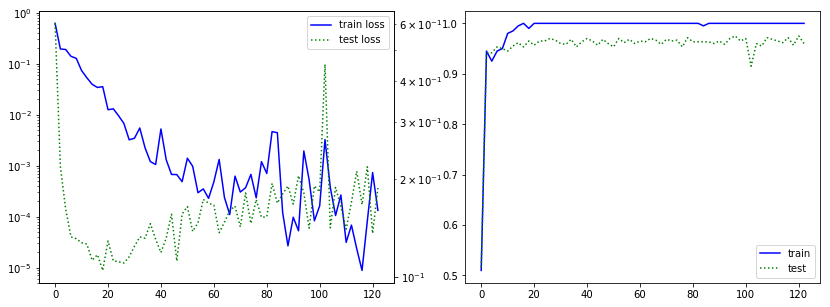

In [18]:
# Loss plot
# Mask on zeros
f, ax = plt.subplots(1,2)
for r in records[-1:]:
    x = np.argwhere(r.testlosses>0)
    ax0, = ax[0].plot(x,r.trnlosses[x],'b-',label='train loss')
    axtwin = ax[0].twinx()
    ax0t, = axtwin.plot(x,r.testlosses[x],'g:',label='test loss')
    l1 = plt.legend([ax0,ax0t],["train loss", "test loss"])
    ax[1].plot(x,r.trnacc[x],'b-',label="train")
    ax[1].plot(x,r.testacc[x],'g:',label="test")
    ax[1].legend()
    ax[0].set_yscale("log", nonposy='mask')
    axtwin.set_yscale("log", nonposy='mask')
    
plt.gcf().set_size_inches(14,5)